In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir

Welcome to JupyROOT 6.22/02


In [32]:
from pyjet import cluster
from pyjet.testdata import get_event
from numpy.lib.recfunctions import append_fields
from numpy.testing import assert_array_equal
import numpy as np

from pyjet import DTYPE_EP

from pyjet import PseudoJet, JetDefinition, ClusterSequence, ClusterSequenceArea
#dir(PseudoJet)

In [94]:
dir(PseudoJet)

['__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'area',
 'child',
 'constituents',
 'constituents_array',
 'e',
 'et',
 'eta',
 'mass',
 'parents',
 'phi',
 'pt',
 'px',
 'py',
 'pz',
 'userinfo']

In [100]:
class particle:
    def __init__(self, pid, fourvector, virtual_photon):
        self.virtual_photon = virtual_photon #z-axis with respect to the lab
        Nu = virtual_photon.E()
        Q2 = -virtual_photon.M2()
        self.proton = ROOT.TLorentzVector()
        self.proton.SetPxPyPzE(0,0,0, 0.938)
        self.W = (virtual_photon + self.proton).M()
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,11.0,11.0)####INCONSISTENT
        part1 = virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        
        self.LorentzVector = fourvector #hadron four-vector
        self.PhiLab = self.LorentzVector.Phi()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star)
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.Xb = Q2/(2*0.938*Nu)

        #'phi =%2.2f'%self.PhiLab,
    def print_properties(self):
        #print ('Hello, let me introduce myself, i am particle pid = ' , self.pid)
        print ('PID', self.pid, ' zh = %2.2f'%self.Zh,  'E = %2.2f'%self.E, 'phi =%2.2f'%self.PhiLab,'theta=%2.2f'%self.LorentzVector.Theta(),'pt %2.2f'%self.Pt)
        #print ('%2.3f,'%self.LorentzVector.Px(),'%2.3f,'%self.LorentzVector.Py(),'%2.3f,'%self.LorentzVector.Pz(), '%2.23f,'%self.LorentzVector.E())


In [130]:
class mytupla:
    def __init__(self):
        
        hadron_variables = ['pid','xf','z','y','ycm','pt','Q2','Xb','Nu','W','phi_pq','theta_pq',
                             'TargType','phi_lab','theta_lab','pos_x','pos_y','pos_z']
        
        self.tupla_hadron = {}
        for var in hadron_variables:
            self.tupla_hadron[var] = []    
            
            
        electron_variables = ['Q2','Xb','Nu','W','costheta','jet_energy','jet_constituents','jet_pt','jet_phi','jet_qt','jet_z','jet_mass']
        self.tupla_electron = {}
        for var in electron_variables:
            self.tupla_electron[var] = [] 

In [131]:

def getDataframes(filename, Target=1,maxevents=1e9,beamenergy=11.0):
    dphi = np.array([])
    ParticlesFromPrevious = []
    try:
        myfile = TFile.Open('%s'%filename,'READ')
    except:
        print("could not open file")

        
    myfile.Print()
    mytree = myfile.Get('RootTuple')
    
    print (filename, ' has ', mytree.GetEntries(), ' entries')
    print ('The max number of events to be analyzes is ', maxevents)
    df = mytupla()    
    
    start = time.time()
    for ievt  in range(mytree.GetEntries()):
        if(ievt%1e5==0):
            print ('Event # ', ievt)
            end = time.time()
            print ('Processed in',  end-start, 'seconds')
            start = time.time()
        mytree.GetEntry(ievt)   
        if mytree.Q2<5.0: continue
        #print ('Q2 = %2.2f, Nu=%2.2f'%(mytree.Q2,mytree.nu))
        if ievt>maxevents: break
        Nu = mytree.nu
        Q2 = mytree.Q2
        phi_e = mytree.phiL 
        E    = beamenergy
        Eprime = E-Nu
        
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,E,E)
        
        #scattered electron
        scattered_e = ROOT.TLorentzVector()
        cos_thetae = 1-Q2/(2*E*Eprime)
        sin_thetae = np.sqrt(1-cos_thetae*cos_thetae)
        scattered_e.SetPxPyPzE(Eprime*sin_thetae*np.cos(phi_e),
                               Eprime*sin_thetae*np.sin(phi_e),
                               Eprime*cos_thetae,
                               Eprime)
        virtual_photon  = incoming_e - scattered_e
        virtual_photon_unitvector = virtual_photon.Vect().Unit()

        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)

        df.tupla_electron['Q2'].append(Q2)
        df.tupla_electron['Xb'].append(0)
        df.tupla_electron['Nu'].append(Nu)
        df.tupla_electron['W'].append(0)
        df.tupla_electron['costheta'].append(cos_thetae)
        
        #print ('Number of particles is ', len(mytree.Px))
        sumz=0.0
        sumE=0.0
        
        particles = np.array([], dtype=DTYPE_EP)
        for i in range(len(mytree.Px)):
            #if abs(mytree.barcode[i]) !=211: continue
            
            i_lv = ROOT.TLorentzVector()    
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.E[i]) #with respect to photon direction
            i_part = particle(mytree.barcode[i], i_lv, virtual_photon)
            #i_part.print_properties()
            if i_part.Zh > 0.0:
                sumz= sumz+i_part.Zh
                sumE= sumE+i_part.LorentzVector.E()
                df.tupla_hadron['TargType'].append(999)
                df.tupla_hadron['pid'].append(i_part.pid)
                df.tupla_hadron['xf'].append(i_part.Xf)
                df.tupla_hadron['z'].append(i_part.Zh)
                df.tupla_hadron['y'].append(i_part.y_star)
                df.tupla_hadron['ycm'].append(i_part.ycm)
                df.tupla_hadron['pt'].append(i_part.LorentzVector.Pt())
                df.tupla_hadron['phi_pq'].append(i_part.PhiPQ)
                df.tupla_hadron['theta_pq'].append(i_part.ThetaPQ)
                df.tupla_hadron['Q2'].append(Q2)
                df.tupla_hadron['Xb'].append(i_part.Xb)
                df.tupla_hadron['Nu'].append(Nu)
                df.tupla_hadron['W'].append(i_part.W)
                df.tupla_hadron['phi_lab'].append(i_part.LorentzVector.Phi())
                df.tupla_hadron['theta_lab'].append(i_part.LorentzVector.Theta())
                df.tupla_hadron['pos_x'].append(mytree.x[i])
                df.tupla_hadron['pos_y'].append(mytree.y[i])
                df.tupla_hadron['pos_z'].append(mytree.z[i])
                #particles = np.append((i_part.LorentzVector.Px(), i_part.LorentzVector.Px(),i_part.LorentzVector.Px(),i_part.LorentzVector.Px()),particles)
                hadron = np.array([(i_part.LorentzVector.E(), i_part.LorentzVector.Px(), i_part.LorentzVector.Py(), i_part.LorentzVector.Pz())], dtype=DTYPE_EP)
                
                particles = np.append(particles, hadron)
        
        
        #print ('Total z =%2.2f'%sumz)   
        #print ('Total E =%2.2f'%sumE)   

        algorithm = 'ee_genkt'
        R = 0.8

        jet_def = JetDefinition(algo = algorithm, R = np.pi/2.0,p=0) #Cambridge Aechen ee gen kt algo.
        cs = ClusterSequence(particles, jet_def, ep=True)

        jets = cs.inclusive_jets()
        #print("The constituents of the first jet")

        #print(jets[0].constituents_array(ep=True))
        #print (jets[0])
        #print (jets[0].e)
        
        jet_z = jets[0].e/Nu
        df.tupla_electron['jet_energy'].append(jets[0].e)
        df.tupla_electron['jet_z'].append(jet_z)
        df.tupla_electron['jet_pt'].append(jets[0].pt)
        df.tupla_electron['jet_qt'].append(jets[0].pt/jet_z)
        df.tupla_electron['jet_phi'].append(jets[0].phi)
        df.tupla_electron['jet_constituents'].append(len(jets[0]))
        df.tupla_electron['jet_mass'].append(jets[0].mass)
        
    end = time.time()
    print ('Processed in',  end-start, 'seconds')
    df_hadron = pd.DataFrame(df.tupla_hadron)
    df_electron = pd.DataFrame(df.tupla_electron)
    return df_electron,df_hadron

In [120]:
df = {}

## Configuration for CLAS6

In [121]:
nevents = 5e6
beamenergy = 11.0
df = {}

In [132]:
df['D_electron'], df['D_hadron'] = getDataframes('/home/miguel/GiBUU/clas12/GiBUU_D.root',maxevents=1e6)

/home/miguel/GiBUU/clas12/GiBUU_D.root  has  5769902  entries
The max number of events to be analyzes is  1000000.0
Event #  0
Processed in 2.1219253540039062e-05 seconds
Event #  100000
Processed in 11.165812969207764 seconds
Event #  200000
Processed in 11.033102989196777 seconds
Event #  300000
Processed in 11.027871370315552 seconds
Event #  400000
Processed in 11.275008916854858 seconds
Event #  500000
Processed in 11.199922800064087 seconds
Event #  600000
Processed in 11.49982213973999 seconds
Event #  700000
Processed in 11.378002882003784 seconds
Event #  800000
Processed in 11.60407304763794 seconds
Event #  900000
Processed in 11.506987571716309 seconds
Event #  1000000
Processed in 11.585536003112793 seconds
Processed in 0.00034117698669433594 seconds
TFile: name=/home/miguel/GiBUU/clas12/GiBUU_D.root, title=, option=READ


In [105]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

## Save dataframes to ROOT files

In [ ]:
to_root(df['D_electron'],'GiBUU_SingleHadron_D.root', key='D_electron')
to_root(df['D_hadron'],'GiBUU_SingleHadron_D.root', key='D_hadron', mode='a')

## Check simulated data

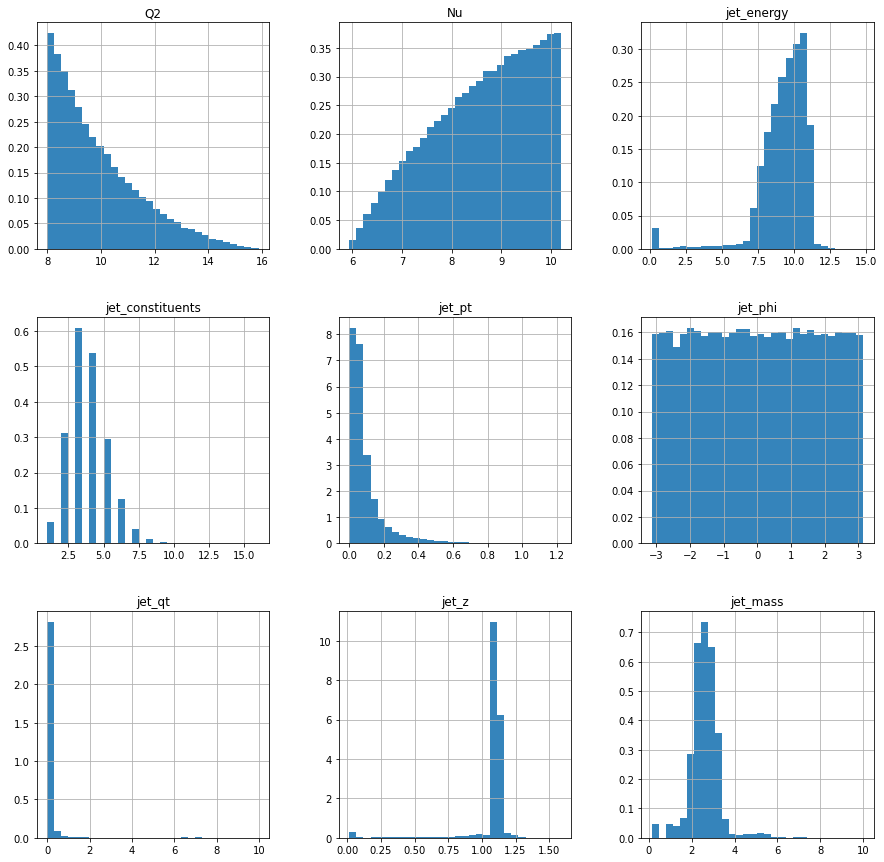

In [133]:
df['D_electron'].query('Q2>8.0').hist(figsize=(15, 15),column=['Q2','Nu','jet_energy','jet_constituents','jet_pt','jet_phi','jet_qt','jet_z','jet_mass'],density=True,alpha=0.9,bins=30)

plt.show()

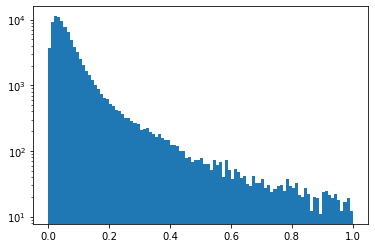

In [127]:
plt.hist(df['D_electron'].query('Q2>8.0')['jet_qt'],range=(0.0,1.0),bins=100)
plt.yscale('log')
plt.show()


In [129]:
np.mean(df['D_electron'].query('Q2>8.0')['jet_constituents'])

3.662264051181727